In [9]:
# default_exp layers

/Users/hmamin/incendio/incendio/callbacks.py:26: UserWarning: Accio not available.
  warnings.warn('Accio not available.')


# Layers

> Custom activations, layers, and layer blocks are contained in this module.

In [1]:
#hide
from nbdev.showdoc import *

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
# export
from abc import abstractmethod, ABC
import copy
from einops.layers.torch import Rearrange
from functools import partial
import numpy as np
from operator import add, truediv, sub
import torch
import torch.nn as nn
import torch.nn.functional as F

from htools import add_docstring
from incendio.core import BaseModel
from incendio.data import probabilistic_hash_tensor
from incendio.utils import concat, weighted_avg, identity

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Used for testing only.
from collections import defaultdict, Counter
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader

from htools import assert_raises, InvalidArgumentError, smap
from incendio.data import probabilistic_hash_item
import pandas_htools

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/hmamin/anaconda3/lib/python3.7/site-packages/pandas_flavor/register.py:31: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'ends' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  register_dataframe_accessor(method.__name__)(AccessorMethod)
/Users/hmamin/anaconda3/lib/python3.7/site-packages/pandas_flavor/register.py:53: UserWarning: registration of accessor <class 'pandas_flavor.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'en

## Activations

In [ ]:
# export
class GRelu(nn.Module):
    """Generic ReLU."""

    def __init__(self, leak=0.0, max=float('inf'), sub=0.0):
        super().__init__()
        self.leak = leak
        self.max = max
        self.sub = sub

    def forward(self, x):
        """Check which operations are necessary to save computation."""
        x = F.leaky_relu(x, self.leak) if self.leak else F.relu(x)
        if self.sub:
            x -= self.sub
        if self.max:
            x = torch.clamp(x, max=self.max)
        return x

    def __repr__(self):
        return f'GReLU(leak={self.leak}, max={self.max}, sub={self.sub})'

In [ ]:
# export
JRelu = GRelu(leak=.1, sub=.4, max=6.0)

In [ ]:
# export
class Mish(nn.Module):
    """OOP form of mish activation.

    Mish: A Self Regularized Non-Monotonic Neural Activation Function
    https://arxiv.org/pdf/1908.08681v1.pdf
    """

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

In [ ]:
# export
def mish(x):
    """Functional form of mish activation.

    Mish: A Self Regularized Non-Monotonic Neural Activation Function
    https://arxiv.org/pdf/1908.08681v1.pdf

    Parameters
    ----------
    x: torch.Tensor[float]
        Input tensor.
    Returns
    -------
    torch.Tensor[float]: Tensor of same shape as input x.
    """
    return x * torch.tanh(F.softplus(x))

In [ ]:
def plot_activations(z, a, mode='scatter', **kwargs):
    """Plot an input tensor and its corresponding activations.  Both tensors
    will be flattened for plotting.
    
    Parameters
    ----------
    z: tf.Tensor
        Tensor containing values to plot on the x axis (we can often think of
        this as the output of a linear layer, where z=f(x) and a=mish(z)).
    a: tf.Tensor
        Tensor containing values to plot on y axis.
    mode: str
        'scatter' for scatter plot or 'plot' for line plot.
    kwargs: Values to be passed to the matplotlib plotting function, such as 
        's' when in 'scatter' mode or 'lw' in 'plot' mode.
        
    Returns
    -------
    None
    """
    plt_func = getattr(plt, mode)
    kwargs = kwargs or {}
    if mode == 'scatter' and not kwargs:
        kwargs = {'s': .75}
    plt_func(z.numpy().flatten(), a.numpy().flatten(), **kwargs)
    plt.axvline(0, lw=.5, alpha=.5)
    plt.axhline(0, lw=.5, alpha=.5)
    plt.show()

In [ ]:
x = torch.arange(-5, 5, .05)
a = mish(x)

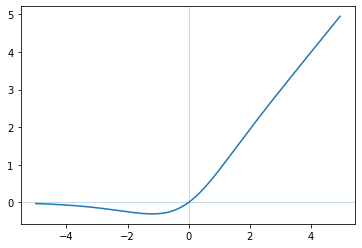

In [ ]:
plot_activations(x, a, 'plot')

## Layer Blocks

In [ ]:
# export
class ConvBlock(nn.Module):
    """Create a convolutional block optionally followed by a batch norm layer.
    """

    def __init__(self, c_in, c_out, kernel_size=3, norm=True, activation=JRelu,
                 **kwargs):
        """
        Parameters
        -----------
        c_in: int
            # of input channels.
        c_out: int
            # of output channels.
        kernel_size: int
            Size of kernel in conv2d layer. An integer argument will be used
            as both the height and width.
        norm: bool
            If True, include a batch norm layer after the conv layer. If False,
            no norm layer will be used. Note that batch norm has learnable
            affine parameters which remove the need for a bias in the preceding
            conv layer. When batch norm is not used, however, the conv layer
            will include a bias term.
        activation: nn.Module
            Activation function to use at the end of the convolutional block.
            (In some cases such as our ResBlock implementation, we pass in None
            so that an extra addition can be performed before the final
            activation.) Do not use the functional form here as it will be
            added to a sequential object. This is an object, not a class.
        kwargs: any
            Additional keyword args are passed to Conv2d. Useful kwargs include
            stride, and padding (see pytorch docs for nn.Conv2d).
        """
        super().__init__()
        self.norm = norm
        layers = [nn.Conv2d(c_in, c_out, kernel_size, bias=not norm, **kwargs)]
        if norm:
            layers.append(nn.BatchNorm2d(c_out))
        if activation is not None:
            layers.append(activation)
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [ ]:
conv = ConvBlock(3, 5, norm=False)
conv

ConvBlock(
  (block): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): GReLU(leak=0.1, max=6.0, sub=0.4)
  )
)

In [ ]:
x = torch.rand(2, 3, 4, 4)
conv(x).shape

torch.Size([2, 5, 2, 2])

In [ ]:
# export
class ResBlock(nn.Module):

    def __init__(self, c_in, kernel_size=3, norm=True, activation=JRelu, 
                 stride=1, padding=1, skip_size=2, **kwargs):
        """Residual block using 2D convolutional layers. Note that kernel_size,
        stride, and pad must be selected such that the height and width of 
        the input remain the same.

        Parameters
        -----------
        c_in: int
            # of input channels.
        kernel_size: int
            Size of filter used in convolution. Default 3 (which becomes 3x3).
        norm: bool
            Specifies whether to include a batch norm layer after each conv
            layer.
        activation: callable
            Activation function to use.
        stride: int
            # of pixels the filter moves between each convolution. Default 1.
        padding: int
            Pixel padding around the input. Default 1.
        skip_size: int
            Number of conv blocks inside the skip connection (default 2).
            ResNet paper notes that skipping a single layer did not show
            noticeable improvements.
        kwargs: any
            Additional kwargs to pass to ConvBlock which will in turn pass them
            to Conv2d. If you accidentally pass in a 'c_out', it will be 
            removed since we need all dimensions to remain unchanged.
        """
        super().__init__()
        # Ensure we don't accidentally pass in a different c_out.
        kwargs.pop('c_out', None)
        self.skip_size = skip_size
        self.layers = nn.ModuleList([
            ConvBlock(c_in, c_in, kernel_size=kernel_size, norm=norm, 
                      activation=None, stride=stride, padding=padding, 
                      **kwargs)
            for i in range(skip_size)
        ])
        self.activation = activation

    def forward(self, x):
        x_out = x
        for i, layer in enumerate(self.layers):
            x_out = layer(x_out)

            # Final activation must be applied after addition.
            if i != self.skip_size - 1:
                x_out = self.activation(x_out)

        return self.activation(x + x_out)

In [ ]:
ResBlock(4)

ResBlock(
  (layers): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (activation): GReLU(leak=0.1, max=6.0, sub=0.4)
)

In [ ]:
ResBlock(4, norm=False)

ResBlock(
  (layers): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (activation): GReLU(leak=0.1, max=6.0, sub=0.4)
)

In [ ]:
# export
@add_docstring(nn.Conv2d)
class ReflectionPaddedConv2d(nn.Module):
    """Conv2d only allows padding_mode of `zeros` or `circular`. This
    layer is a quick way for us to use reflection padding.
    """
    
    def __init__(self, in_channels, out_channels, padding=1, 
                 kernel_size=3, **kwargs):
        """Do not specify a padding mode.
        """
        super().__init__()
        if 'padding_mode' in kwargs: 
            raise InvalidArgumentError('Remove `padding_mode` from arguments.')
        self.reflect = nn.ReflectionPad2d(padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              padding=0)
    
    def forward(self, x):
        x = self.reflect(x)
        return self.conv(x)

In [ ]:
def show_img(img):
    plt.imshow(img.permute(1, 2, 0) / 255)
    plt.show()

In [ ]:
rconv = ReflectionPaddedConv2d(3, 3, kernel_size=1, padding=2)
rconv

ReflectionPaddedConv2d(
  (reflect): ReflectionPad2d((2, 2, 2, 2))
  (conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
)

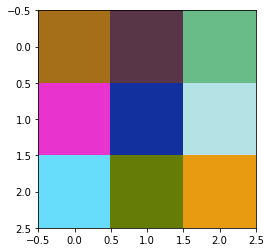

In [ ]:
x = torch.randint(255, (1, 3, 3, 3)).float()
show_img(x[0])

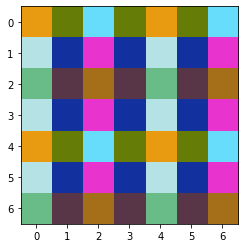

In [ ]:
x2 = rconv.reflect(x)
show_img(x2[0])

In [ ]:
# Tests
assert nn.Conv2d.__doc__ in ReflectionPaddedConv2d.__doc__

with assert_raises(InvalidArgumentError):
    ReflectionPaddedConv2d(3, 3, padding_mode='zeros')

As expected, got InvalidArgumentError(Remove `padding_mode` from arguments.).


In [5]:
# export
class SmoothSoftmaxBase(nn.Module):
    """Parent class of SmoothSoftmax and SmoothLogSoftmax (softmax or log
    softmax with temperature baked in). There shouldn't be a need to
    instantiate this class directly.
    """

    def __init__(self, log=False, temperature='auto', dim=-1):
        """
        Parameters
        ----------
        log: bool
            If True, use log softmax (if this is the last activation in a
            network, it can be followed by nn.NLLLoss). If False, use softmax
            (this is more useful if you're doing something attention-related:
            no standard torch loss functions expect softmax outputs). This
            argument is usually passed implicitly by the higher level interface
            provided by the child classes.
        temperature: float or str
            If a float, this is the temperature to divide activations by before
            applying the softmax. Values larger than 1 soften the distribution
            while values between 0 and 1 sharpen it. If str ('auto'), this will
            compute the square root of the last dimension of x's shape the
            first time the forward method is called and use that for subsequent
            calls.
        dim: int
            The dimension to compute the softmax over.
        """
        super().__init__()
        self.temperature = None if temperature == 'auto' else temperature
        self.act = nn.LogSoftmax(dim=dim) if log else nn.Softmax(dim=dim)

    def forward(self, x):
        """
        Parameters
        ----------
        x: torch.float

        Returns
        -------
        torch.float: Same shape as x.
        """
        # Slightly odd way to do this but we're trying to avoid an extra if
        # statement because temperature only needs to be set once and we could
        # plausibly call this method millions of times during training.
        try:
            return self.act(x.div(self.temperature))
        except TypeError:
            self.temperature = np.sqrt(x.shape[-1])
            return self.forward(x)
        except Exception as e:
            raise e

In [6]:
# export
class SmoothSoftmax(SmoothSoftmaxBase):

    def __init__(self, temperature='auto', dim=-1):
        super().__init__(log=False, temperature=temperature, dim=dim)

In [7]:
# export
class SmoothLogSoftmax(SmoothSoftmaxBase):

    def __init__(self, temperature='auto', dim=-1):
        super().__init__(log=True, temperature=temperature, dim=dim)

In [8]:
# export
class SpatialSoftmax(nn.Module):
    """Apply softmax over the height and width dimensions of a batch of image
    tensors (or image-like tensors). Concretely, inputs will usually have
    shape (batch size, channels, height, width), while outputs will have the
    same shape but values for each feature map will now sum to 1. Essentially,
    we now have a heatmap of what region in each image to focus on.
    """
    
    def __init__(self, temperature='auto', log=False):
        super().__init__()
        cls = SmoothLogSoftmax if log else SmoothSoftmax
        self.act = cls(temperature)
        
    def forward(self, x):
        # Should work on any tensor with shape (bs, ..., h, w).
        flattened = self.act(x.view(*x.shape[:-2], -1))
        return flattened.view(*x.shape)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# export
class Dropin(nn.Module):
    """Additive dropout. This injects small amounts of noise into a model
    in the form of randomly generated floats from a zero-centered
    gaussian distribution (variance can be adjusted). This does nothing 
    in eval mode. Unlike Dropout, this does not scale weights during 
    training since it does not bias them in any direction.
    """
    
    def __init__(self, scale=.5):
        """
        Parameters
        ----------
        scale: float
            Used to scale the magnitude of the random noise. Keep in mind 
            that the scalar term is square rooted, so the relationship
            will not be linear. Relatively large values (e.g. 1.0) will have
            a stronger regularizing effect, while small values (e.g. 0.1)
            will have a slight regularizing effect. There is no max value
            enforced, so it's up to the user to select a reasonable value.
        """
        super().__init__()
        self.scale = scale
        
    def forward(self, x):
        if not self.training:
            return x
        
        # Storing noise allows us to run diagnostics.
        self.noise = torch.randn_like(x) * np.sqrt(self.scale / x.shape[-1])
        return x + self.noise

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.drop = Dropin()
        
    def forward(self, x):
        return self.drop(x)

In [ ]:
net = Net()
x = torch.randn(8, 128, 128, 3)
assert np.corrcoef(net(x).flatten(), x.flatten())[0][1] > .9

In [ ]:
net.eval()
assert torch.eq(net(x), x).all()
assert not net.drop.training

In [ ]:
def simulate_activation_stats(scale=1.0, trials=10_000):
    act_stats = defaultdict(list)
    noise_stats = defaultdict(list)
    
    drop = Dropin(scale)
    for _ in range(trials):
        x = torch.randn(3, 4, dtype=torch.float)
        z = drop(x)
        noise = drop.noise
        noise_stats['mean'].append(noise.mean())
        noise_stats['std'].append(noise.std())
        noise_stats['act_corr'].append(
            np.corrcoef(z.flatten(), noise.flatten())[0][1]
        )
        
        act_stats['mean'].append(z.mean())
        act_stats['std'].append(z.std())
        act_stats['x_corr'].append(
            np.corrcoef(z.flatten(), x.flatten())[0][1]
        )

    return pd.DataFrame(dict(
        act={k: np.mean(v).round(4) for k, v in act_stats.items()}, 
        noise={k: np.mean(v).round(4) for k, v in noise_stats.items()}
    ))

In [ ]:
for scale in [10, 1, .75, .5, .25, .1]:
    print('\n', scale)
    simulate_activation_stats(scale, 1_000).pprint()


 10


,act,noise
mean,0.0132,0.0094
std,1.8189,1.5192
x_corr,0.5324,NaN
act_corr,NaN,0.8304



 1


,act,noise
mean,-0.0141,0.0034
std,1.0921,0.4870
x_corr,0.8855,NaN
act_corr,NaN,0.4282



 0.75


,act,noise
mean,-0.0015,0.0022
std,1.0633,0.4240
x_corr,0.9100,NaN
act_corr,NaN,0.3899



 0.5


,act,noise
mean,0.0107,0.0008
std,1.0558,0.3442
x_corr,0.9409,NaN
act_corr,NaN,0.3235



 0.25


,act,noise
mean,0.0098,-0.0057
std,1.0013,0.2461
x_corr,0.9667,NaN
act_corr,NaN,0.2298



 0.1


,act,noise
mean,-0.0057,-0.0014
std,0.9969,0.1533
x_corr,0.9868,NaN
act_corr,NaN,0.1394


In [ ]:
# export
class LinearSkipBlock(nn.Module):
    """This lets us easily create residual block equivalents with linear
    layers.
    """
    
    def __init__(self, x_dim, layer_dims, op, activation=mish):
        """
        Parameters
        ----------
        x_dim: int
            Size of input tensor.
        layer_dims: Iterable[int]
            Size of each layer. The length of this list will be the skip size
            (2 is probably a reasonable starting point).
        op: function
            This will be called on the input x and the processed x in the
            forward method. This is a concatenation for dense blocks and an
            addition for residual blocks, but any operation is possible.
        activation: callable
            Activation function or callable class. This will be applied after
            each layer. The final activation is applied after the `op` 
            function.
        """
        super().__init__()
        self.skip_size = len(layer_dims)
        self.activation = activation
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out
                                     in zip([x_dim]+list(layer_dims), 
                                            layer_dims)])
        self.op = op
            
    def forward(self, x):
        out = x
        for i, layer in enumerate(self.layers, 1):
            out = layer(out)
            if i < self.skip_size: out = self.activation(out)
        return self.activation(self.op(x, out))

In [ ]:
# export
class LinearResBlock(LinearSkipBlock):
    """Equivalent of ResNet block with linear layers."""
    
    def __init__(self, x_dim, hidden_dims, activation=mish):
        if hidden_dims[-1] != x_dim:
            raise InvalidArgumentError(
                'Last hidden dimension must match input dimension.'
            )
        super().__init__(x_dim, hidden_dims, add, activation)

In [ ]:
# export
class LinearDenseBlock(LinearSkipBlock):
    """Equivalent of DenseNet block with linear layers."""
    
    def __init__(self, x_dim, hidden_dims, activation=mish):
        super().__init__(x_dim, hidden_dims, concat, activation)

In [ ]:
# export
class WeightedLinearResBlock(LinearSkipBlock):
    """Like a LinearResBlock but takes a weighted average of the input and 
    output rather than adding them. Addition gives them equal weight and we 
    may want to weight the output more heavily.
    """
    
    def __init__(self, x_dim, hidden_dims, weights=(.25, .75),
                 activation=mish):
        super().__init__(x_dim, hidden_dims, 
                         partial(weighted_avg, weights=list(weights)),
                         activation)

In [ ]:
# export
class SkipConnection(nn.Module):
    """More generalized version of skip connection. Eventually maybe rewrite
    various res/dense/weighted conv blocks with this.
    
    Examples
    --------
    >> x = torch.randn(3, 4)
    >> dense = nn.Linear(4, 2)
    >> dense(x).shape
    
    torch.Size([3, 2])
    
    >> skip = SkipConnection(dense, op='cat')
    >> skip(x).shape
    
    torch.Size([3, 6])
    
    >> skip = SkipConnection(dense, op='add')
    >> skip(x).shape
    
    RuntimeError: The size of tensor a (4) must match the size of tensor b (2)
    at non-singleton dimension 1
    """
    
    def __init__(self, block, op='add', input_weight=None):
        """
        Parameters
        ----------
        block: nn.Module
            A torch layer/model that takes in some input x (and optionally
            other args/kwargs) and performs some computations on it. When 
            using op='add', this should output a tensor with the same shape
            as its first input.
        op: str
            One of ('add', 'cat', 'weighted_avg'). This determines how the
            input will be attached to the output. If you choose 'cat',
            concatenation will occur over the last axis and input will precede
            output.
        input_weight: float or None
            If op='weighted_avg', you must provide a float in (0, 1) that
            determines how heavily to weight the input x. For example, 0.2
            means the output of `block` will be much more heavily weighted
            than the input tensor, while 0.5 is equivalent to computing the 
            mean (and in most cases is essentially equivalent to computing
            the sum).
        """
        super().__init__()
        self.block = block
        if op == 'add':
            self.op = torch.add
        elif op == 'cat':
            self.op = self._cat
        elif op == 'weighted_avg':
            if input_weight is None or input_weight <= 0 or input_weight >= 1:
                raise ValueError('input_weight must be a float in (0, 1) '
                                 'when op="weighted".')
            self.weights = input_weight, 1-input_weight
            self.op = self._weighted_avg
        else:
            raise ValueError('op must be in ("add", "cat", "weighted_avg").')
        
    def forward(self, x, *args, **kwargs):
        """
        Parameters
        ----------
        x: torch.Tensor
            This first item is considered to be the input which will be 
            combined with the output of self.block.
        args, kwargs: any
            Additional args will be forwarded to self.block.
            
        Returns
        -------
        torch.Tensor: Should have same shape as x unless you're making use of
        broadcasting, which should rarely be needed here.
        """
        return self.op(x, self.block(x, *args, **kwargs))
        
    @staticmethod
    def _cat(x1, x2):
        """Wrapper since torch.cat has a different interface than torch.add
        (list of args vs. *args).
        """
        return torch.cat([x1, x2], dim=-1)
    
    def _weighted_avg(x1, x2):
        """In our use case, the first tensor will be the original input tensor
        and the second will be the output of self.block.
        """
        return self.weights[0]*x1 + self.weights[1]*x2

## Embeddings and Encodings

In [12]:
# export
def trunc_normal_(x, mean=0.0, std=1.0):
    """Ported from fastai to remove dependency: 
    
    Truncated normal initialization.
    From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    """
    return x.normal_().fmod_(2).mul_(std).add_(mean)

In [50]:
# export
class InitializedEmbedding(nn.Embedding):
    """Same as nn.Embedding but with truncated normal initialization. This
    also differs from fastai's Embedding class in that it allows padding.
    """
        
    def reset_parameters(self):
        with torch.no_grad():
            trunc_normal_(self.weight, std=.01)
            if self.padding_idx is not None:
                torch.zero_(self.weight[self.padding_idx])

In [51]:
InitializedEmbedding(4, 3, 0).weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0031, -0.0033, -0.0013],
        [ 0.0076, -0.0107,  0.0008],
        [ 0.0119, -0.0014,  0.0027]], requires_grad=True)

In [ ]:
InitializedEmbedding(4, 3, 3).weight

Parameter containing:
tensor([[ 0.0038, -0.0103, -0.0074],
        [ 0.0104, -0.0036,  0.0039],
        [-0.0007,  0.0008,  0.0191],
        [ 0.0000,  0.0000,  0.0000]], requires_grad=True)

In [ ]:
InitializedEmbedding(4, 3).weight

Parameter containing:
tensor([[-0.0082,  0.0058, -0.0055],
        [-0.0104, -0.0144,  0.0036],
        [ 0.0028, -0.0020, -0.0009],
        [ 0.0046, -0.0088, -0.0026]], requires_grad=True)

In [59]:
# export
class BloomEmbedding(nn.Module):
    """Bloom Embedding layer for memory-efficient word representations.
    Each word is encoded by a combination of rows of the embedding
    matrix. The number of rows can therefore be far lower than the number
    of words in our vocabulary while still providing unique representations.
    The reduction in rows allows us to use memory in other ways: a larger
    embedding dimension, more or larger layers after the embedding,
    larger batch sizes, etc.
    
    Note that if hashing is done in the Dataset, we could use a simple
    nn.EmbeddingBag to achieve the same thing. Many users have reported 
    poor performance with this layer though (especially on CPU, but in some
    cases on GPU) so I stick with the standard Embedding. We also bake in
    the truncated normal intialization provided by fastai, with a slight tweak
    to allow a row for padding.
    """
    
    def __init__(self, n_emb=251, emb_dim=100, n_hashes=4, padding_idx=0,
                 pre_hashed=False):
        """
        Parameters
        ----------
        n_emb: int
            Number of rows to create in the embedding matrix. A prime
            number is recommended. Lower numbers will be more 
            memory-efficient but increase the chances of collisions.
        emb_dim: int
            Size of each embedding. If emb_dim=100, each word will
            be represented by a 100-dimensional vector.
        n_hashes: int
            This determines the number of hashes that will be taken
            for each word index, and as a result, the number of rows
            that will be summed to create each unique representation.
            The higher the number, the lower the chances of a collision.
        padding_idx: int or None
            If an integer is provided, this will set aside the corresponding
            row in the embedding matrix as a vector of zeros. If None, no
            padding vector will be allocated.
        pre_hashed: bool
            Pass in True if the input tensor will already be hashed by the
            time it enters this layer (you may prefer pre-compute the hashes 
            in the Dataset to save computation time during training). In this
            scenario, the layer is a simple embedding bag with mode "sum". 
            Pass in False if the inputs will be word indices that have not yet
            been hashed. In this case, hashing will be done inside the 
            `forward` call.
            
        Suggested values for a vocab size of ~30,000:
        
        | n_emb | n_hashes | unique combos |
        |-------|----------|---------------|
        | 127   | 5        | 29,998        |
        | 251   | 4        | 29,996        |
        | 997   | 3        | 29,997        |
        | 5,003 | 2        | 29,969        |
        """
        super().__init__()
        self.n_emb = n_emb
        self.emb = InitializedEmbedding(n_emb, emb_dim, padding_idx)
        self.n_hashes = n_hashes
        self.pad_idx = padding_idx
        self.pre_hashed = pre_hashed
        self.process_fn = identity if pre_hashed else \
            partial(probabilistic_hash_tensor, n_buckets=n_emb,
                    n_hashes=n_hashes, pad_idx=padding_idx)
        # Makes interface consistent with nn.Embedding. Don't change name.
        self.embedding_dim = self.emb.embedding_dim
        
    def forward(self, x):
        """
        Parameters
        ----------
        x: torch.LongTensor
            Input tensor of word indices (bs x seq_len) if pre_hashed is 
            False. Hashed indices (bs x seq_len x n_hashes) if pre_hashed is 
            False.
            
        Returns
        -------
        torch.FloatTensor: Words encoded with combination of embeddings.
            (bs x seq_len x emb_dim)
        """
        # If not pre-hashed: (bs, seq_len) -> hash -> (bs, seq_len, n_hashes)
        hashed = self.process_fn(x)
        # (bs, seq_len, n_hashes, emb_dim) -> sum -> (bs, seq_len, emb_dim)
        return self.emb(hashed).sum(-2)

In [42]:
class Data(Dataset):
    
    def __init__(self, sentences, labels, seq_len):
        x = [s.split(' ') for s in sentences]
        self.w2i = self.make_w2i(x)
        self.seq_len = seq_len
        self.x = self.encode(x)
        self.y = torch.tensor(labels)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.y)
    
    def make_w2i(self, tok_rows):
        return {k: i for i, (k, v) in 
                enumerate(Counter(chain(*tok_rows)).most_common(), 1)}
    
    def encode(self, tok_rows):
        enc = np.zeros((len(tok_rows), self.seq_len), dtype=int)
        for i, row in enumerate(tok_rows):
            trunc = [self.w2i.get(w, 0) for w in row[:self.seq_len]]
            enc[i, :len(trunc)] = trunc
        return torch.tensor(enc)

In [43]:
sents = [
    'I walked to the store so I hope it is not closed.',
    'The theater is closed today and the sky is grey.',
    'His dog is brown while hers is grey.'
]
labels = [0, 1, 1]

In [44]:
ds = Data(sents, labels, 10)
ds[1]

(tensor([13, 14,  1, 15, 16, 17,  3, 18,  1,  4]), tensor(1))

In [45]:
dl = DataLoader(ds, batch_size=3)
x, y = next(iter(dl))
x, y

(tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
         [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
         [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]]),
 tensor([0, 1, 1]))

In [46]:
x, y = next(iter(dl))
x, y

(tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
         [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
         [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]]),
 tensor([0, 1, 1]))

In [47]:
be = BloomEmbedding(11, 4)
be.emb.weight

Parameter containing:
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.3866e-02,  2.7083e-03,  1.9108e-03,  2.3947e-03],
        [ 5.0557e-03, -4.8774e-03,  1.5206e-03,  1.0080e-03],
        [ 4.5406e-05,  2.1932e-03, -9.5886e-03,  4.7936e-03],
        [-9.7800e-03,  1.9145e-02,  2.4422e-03,  1.2713e-02],
        [ 1.2850e-02,  4.0345e-03, -1.9255e-02, -2.5600e-03],
        [ 5.7765e-03,  1.4253e-02,  1.8160e-02, -1.6686e-02],
        [ 1.2343e-02,  2.8021e-03,  9.5432e-04,  4.2866e-03],
        [ 6.4279e-03, -3.4935e-03, -1.9902e-03, -9.9574e-03],
        [ 9.7122e-04, -6.8190e-03, -1.2612e-02, -1.6921e-03],
        [-1.1588e-02, -4.2316e-03, -9.5648e-03, -6.5988e-03]],
       requires_grad=True)

In [ ]:
x

tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
        [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
        [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]])

In [ ]:
# (bs x seq_len) -> (bs -> seq_len -> emb_size)
y = be(x)
y.shape

torch.Size([3, 10, 4])

In [ ]:
y[0]

tensor([[ 0.0363, -0.0098,  0.0052,  0.0023],
        [ 0.0337, -0.0130, -0.0147, -0.0183],
        [ 0.0075, -0.0316,  0.0120,  0.0236],
        [ 0.0304, -0.0328,  0.0388, -0.0240],
        [ 0.0144,  0.0004, -0.0022,  0.0019],
        [ 0.0084,  0.0117,  0.0089, -0.0284],
        [ 0.0363, -0.0098,  0.0052,  0.0023],
        [ 0.0177, -0.0087,  0.0344, -0.0139],
        [ 0.0272, -0.0108, -0.0036,  0.0130],
        [ 0.0035, -0.0162,  0.0048,  0.0260]], grad_fn=<SelectBackward>)

Below, we show by step how to get from x to y. This is meant to demonstrate the basic mechanism, not to show how PyTorch actually implements this under the hood. Let's look at a single row of x, corresponding to 1 sentence where each word is mapped to its index in the vocabulary.

In [ ]:
x[0]

tensor([ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1])

Next, we hash each item.

In [ ]:
hashed = [probabilistic_hash_item(i.item(), 11, int, 4) for i in x[0]]
hashed

[[8, 2, 7, 8],
 [2, 8, 1, 2],
 [6, 6, 10, 10],
 [10, 5, 5, 5],
 [6, 9, 7, 2],
 [5, 9, 4, 0],
 [8, 2, 7, 8],
 [5, 10, 8, 9],
 [7, 8, 6, 2],
 [6, 10, 6, 0]]

Then use each row of hashed integers to index into the embedding weight matrix.

In [ ]:
output = []
for row in hashed:
    row_out = be.emb.weight[row]
    output.append(row_out)
output = torch.stack(output)
print(output.shape)
output[:2]

torch.Size([10, 4, 4])


tensor([[[ 0.0089,  0.0007,  0.0076,  0.0034],
         [ 0.0097,  0.0003, -0.0098, -0.0082],
         [ 0.0089, -0.0114, -0.0001,  0.0037],
         [ 0.0089,  0.0007,  0.0076,  0.0034]],

        [[ 0.0097,  0.0003, -0.0098, -0.0082],
         [ 0.0089,  0.0007,  0.0076,  0.0034],
         [ 0.0054, -0.0142, -0.0027, -0.0052],
         [ 0.0097,  0.0003, -0.0098, -0.0082]]], grad_fn=<SliceBackward>)

Finally, we sum up the embedding rows. Above, each word is represented by four rows of the embedding matrix. After summing, we get a single vector for each word.

In [ ]:
output = output.sum(-2)
output

tensor([[ 0.0363, -0.0098,  0.0052,  0.0023],
        [ 0.0337, -0.0130, -0.0147, -0.0183],
        [ 0.0075, -0.0316,  0.0120,  0.0236],
        [ 0.0304, -0.0328,  0.0388, -0.0240],
        [ 0.0144,  0.0004, -0.0022,  0.0019],
        [ 0.0084,  0.0117,  0.0089, -0.0284],
        [ 0.0363, -0.0098,  0.0052,  0.0023],
        [ 0.0177, -0.0087,  0.0344, -0.0139],
        [ 0.0272, -0.0108, -0.0036,  0.0130],
        [ 0.0035, -0.0162,  0.0048,  0.0260]], grad_fn=<SumBackward1>)

 Notice that the values now match the output of our embedding layer.

In [ ]:
assert torch.isclose(output, y[0]).all()

Axial encodings are intended to work as positional embeddings for transformer-like architectures. It's possible they could work for word embeddings as well, similar to our use of Bloom embeddings. However, the standard version of axial encodings results in similar vectors for adjacent indices - this makes some sense for positional indices, but for word indices it might require some additional preprocessing. For example, we could compress word embeddings down to 1 dimension and sort them, or simply sort by number of occurrences in our corpus which could be considered to be doing the same thing. Large chunks of the outputs vectors will be shared among different inputs, whereas Bloom embeddings seem like they would have a greater capacity to avoid this issue.

In [61]:
# export
class AxialEncoding(nn.Module):
    """Axial encodings. These are intended to encode position in a sequence
    (e.g. index in a sentence). It's possible we could adapt these for use as
    word embeddings but this would likely require some experimentation (for
    example, words would likely need to be sorted in a thoughtful manner 
    (e.g. pre-trained embeddings compressed to 1D?) since adjacent inputs will
    share half of their encodings).
    """

    def __init__(self, vocab_dim, emb_dim, pad_idx=None):
        """
        Parameters
        ----------
        vocab_dim: int
            Number of words in vocab (or max sequence length if being used for
            positional encodings).
        emb_dim: int
            Size of embedding vectors (often numbers like 50, 100, 300).
        pad_idx: int or None
            If necessary, pass in an integer to represent padding. Otherwise
            no rows are reserved for padding.
        """
        super().__init__()
        if emb_dim % 2 != 0:
            raise ValueError('emb_dim must be an even number.')
            
        self.v = self._decompose_mult(vocab_dim)
        self.e = self._decompose_add(emb_dim)
        self.emb = nn.ModuleList(InitializedEmbedding(self.v, self.e, pad_idx) 
                                 for _ in range(2))
        # Makes interface consistent with nn.Embedding. Don't change name.
        self.embedding_dim = self.e * 2
    
    def _decompose_mult(self, dim):
        return int(np.ceil(np.sqrt(dim)))
    
    def _decompose_add(self, dim):
        return int(np.ceil(dim / 2))
    
    def forward(self, idx):
        return torch.cat([self.emb[0](idx%self.v), self.emb[1](idx//self.v)], 
                         dim=-1)

In [63]:
# export
class MultiAxialEncoding(nn.Module):
    """Adapted axial encodings to allow for more than 2 embedding matrices.
    These are intended to encode position in a sequence (e.g. index in a 
    sentence) but might work as word embeddings. This version may be better 
    suited for that use case because using more blocks results in fewer shared
    numbers in the output vectors of adjacent inputs.
    
    Some experimentation is still required for this use case (for
    example, words would likely need to be sorted in a thoughtful manner 
    (e.g. pre-trained embeddings compressed to 1D?) since adjacent inputs will
    share half of their encodings).
    
    I made this separate from AxialEncoding (at least for now) since I made a
    few tweaks to the original design to make this possible and I wanted to 
    preserve the option to use the simpler, well-tested method 
    (AxialEncoding). Here, we use a probabilistic hashing scheme to map each
    input to multiple embedding rows, while the original design uses 
    x%v and x//v.
    """

    def __init__(self, vocab_dim, emb_dim, n_blocks=2, pre_hashed=False, 
                 pad_idx=None):
        super().__init__()
        # Must set n_blocks before computing v or e.
        self.n_blocks = n_blocks
        self.v = self._decompose_mult(vocab_dim)
        self.e = self._decompose_add(emb_dim)
        self.pre_hashed = pre_hashed
        # Must set emb blocks before defining process_fn.
        self.emb = nn.ModuleList(InitializedEmbedding(self.v, self.e, pad_idx) 
                                 for _ in range(n_blocks))
        self.process_fn = identity if pre_hashed else \
            partial(probabilistic_hash_tensor, n_buckets=self.v, 
                    n_hashes=len(self.emb), pad_idx=pad_idx)
        # Makes interface consistent with nn.Embedding. Don't change name.
        self.embedding_dim = self.e * self.n_blocks
    
    def _decompose_mult(self, dim):
        return int(np.ceil(dim ** (1 / self.n_blocks)))
    
    def _decompose_add(self, dim):
        return int(np.ceil(dim // self.n_blocks))
    
    def forward(self, idx):
        # Hashed shape: (bs, seq_len, n_hashes)
        xhash = self.process_fn(idx)
        # Each embedding takes in a tensor of shape (bs, seq_len).
        res_blocks = [e(hashed.squeeze()) for e, hashed in 
                      zip(self.emb, torch.chunk(xhash, xhash.shape[0], -1))]
        return torch.cat(res_blocks, dim=-1)

In [64]:
def reduction_ratio(ax, vocab_size, emb_dim):
    """For testing purposes. Lets us compare the number of weights in a
    traditional embedding matrix vs. the number of weights in our axial
    encoding.
    """
    normal_n = vocab_size * emb_dim
    ax_n = sum(e.weight.numel() for e in ax.emb)
    print('Normal embedding weights:', normal_n)
    print('Axial encoding weights:', ax_n)
    print('Difference:', normal_n - ax_n)
    print('Ratio:', normal_n / ax_n)

In [65]:
vocab_size = 30_000
emb_dim = 100
bs = 12

ax = AxialEncoding(vocab_size, emb_dim)
x = torch.randint(0, vocab_size, (bs, 2))
print(x.shape)
ax

torch.Size([12, 2])


AxialEncoding(
  (emb): ModuleList(
    (0): InitializedEmbedding(174, 50)
    (1): InitializedEmbedding(174, 50)
  )
)

In [ ]:
res = ax(x)
print(res.shape)

torch.Size([12, 2, 100])


In [ ]:
reduction_ratio(ax, vocab_size, emb_dim)

Normal embedding weights: 3000000
Axial encoding weights: 17400
Difference: 2982600
Ratio: 172.41379310344828


In [ ]:
vocab_size = 30_000
emb_dim = 100
bs = 12

ax = MultiAxialEncoding(vocab_size, emb_dim, 4)
x = torch.randint(0, vocab_size, (bs, 2))
print(x.shape)
ax

torch.Size([12, 2])


MultiAxialEncoding(
  (emb): ModuleList(
    (0): Embedding(14, 25)
    (1): Embedding(14, 25)
    (2): Embedding(14, 25)
    (3): Embedding(14, 25)
  )
)

In [ ]:
res1 = ax(x)
res1.shape

torch.Size([12, 2, 100])

In [ ]:
vocab_size = 30_000
emb_dim = 100
bs = 12

ax_pre = MultiAxialEncoding(vocab_size, emb_dim, 4, pre_hashed=True)
ax_pre

MultiAxialEncoding(
  (emb): ModuleList(
    (0): Embedding(14, 25)
    (1): Embedding(14, 25)
    (2): Embedding(14, 25)
    (3): Embedding(14, 25)
  )
)

By setting the weights of our pre-hashed embedding to the weights of our hashing embedding, we can check that the outputs are ultimately the same.

In [ ]:
for e, e_pre in zip(ax.emb, ax_pre.emb):
    e_pre.weight.data = e.weight.data

In [ ]:
xhash = probabilistic_hash_tensor(x, 14, 4)
res2 = ax_pre(xhash)
res2.shape

torch.Size([12, 2, 100])

In [ ]:
(res1 == res2).all()

tensor(True)

In [ ]:
reduction_ratio(ax_pre, vocab_size, emb_dim)

Normal embedding weights: 3000000
Axial encoding weights: 1400
Difference: 2998600
Ratio: 2142.8571428571427


I imagine that as we increase `n_blocks`, there's likely a point where we simply won't have enough weights to encode the amount of information that's present in the data. It would take some experimentation to find where that line is, however.

In [ ]:
ax_large = MultiAxialEncoding(vocab_size, emb_dim, 8, pre_hashed=True)
ax_large

MultiAxialEncoding(
  (emb): ModuleList(
    (0): Embedding(4, 12)
    (1): Embedding(4, 12)
    (2): Embedding(4, 12)
    (3): Embedding(4, 12)
    (4): Embedding(4, 12)
    (5): Embedding(4, 12)
    (6): Embedding(4, 12)
    (7): Embedding(4, 12)
  )
)

In [ ]:
reduction_ratio(ax_large, vocab_size, emb_dim)

Normal embedding weights: 3000000
Axial encoding weights: 384
Difference: 2999616
Ratio: 7812.5


## Attention

Some GPT2-esque layers. These were mostly intuition-building exercises - more thoroughly tested implementations likely exist in Huggingface.

In [10]:
# export
class Projector(nn.Module):
    """Project input into multiple spaces. Used in DotProductAttention to
    generate queries/keys/values.
    """
    
    def __init__(self, n_in, n_out_single=None, spaces=3):
        """
        Parameters
        ----------
        n_in: int
            Size of input feature dimension, where input is (bs, n_in) or
            (bs, seq_len, n_in). If the latter, this ONLY transforms the last 
            dimension. If you want to take multiple dimensions of information 
            into account simultaneously, you can flatten the input prior to 
            passing it in.
        n_out_single: int or None
            This determines the size of the feature dimension in each new 
            space. By default, this will be the same as n_in.
        spaces: int
            Number of spaces to project the input into. Default is 3 because
            we commonly use this to generate queries, keys, and values for
            attention computations.
        """
        super().__init__()
        self.spaces = spaces
        self.n_in = n_in
        self.n_out_single = n_out_single or n_in
        self.spaces = spaces
        self.n_out = self.n_out_single * self.spaces
        self.fc = nn.Linear(self.n_in, self.n_out)
        
    def forward(self, x):
        """
        Parameters
        ----------
        x: torch.Tensor
            Shape (bs, n_in) or (bs, seq_len, n_in).
            
        Returns
        -------
        tuple[torch.Tensor]: Tuple of `spaces` tensors where each tensor has
        shape (bs, n_out_single) or (bs, seq_len, n_out_single), depending on
        the input shape.
        """
        return self.fc(x).chunk(self.spaces, dim=-1)

In [ ]:
# export
class DotProductAttention(nn.Module):
    """GPT2-style attention block. This was mostly an intuition-building
    exercise - in practice, Huggingface provides layers that should probably
    be used instead.
    """
    
    def __init__(self, n_in, n_out=None, nf=None, n_heads=12,
                 temperature='auto', p1=0.1, p2=0.1, return_attn=False):
        """
        Parameters
        ----------
        n_in: int
            Last dimension of input, usually embedding dimension.
        n_out: int or None
            Size of output vectors. By default, this will be the same as the 
            input.
        nf: int or None
            Size ("nf = number of features") of queries/keys/values. 
            By default, this will be the same as n_in. Must be divisible by
            n_heads.
        n_heads: int
            Number of attention heads to use. nf must be divisible
            by this as each projected vector will be divided evenly among
            each head.
        temperature: str or float
            If str, must be "auto", meaning softmax inputs will be scaled by
            sqrt(n_proj_single). You can also specify a float, where values
            <1 sharpen the distribution (usually not what we want here) and
            values greater than one soften it (allowing attention head to 
            route more information from multiple neurons rather than almost 
            all from one).
        p1: float
            Value in (0.0, 1.0) setting the dropout probability on the 
            attention weights.
        p2: float
            Value in (0.0, 1.0) setting dropout probability following the 
            output layer.
        return_attn: bool
            If True, the `forward` method will return a tuple of 
            (output, attention_weights) tensors. If False (the default), just
            return the output tensor.
        """
        super().__init__()
        nf = nf or n_in
        n_out = n_out or n_in
        assert nf % n_heads == 0, \
            'n_proj_single must be divisible by n_heads'
        
        self.proj_in = Projector(n_in, nf, spaces=3)
        # Reshape so hidden dimension is split equally between each head.
        self.head_splitter = Rearrange('bs seq (heads f) -> bs heads seq f', 
                                       heads=n_heads)
        self.soft = SmoothSoftmax(temperature)
        self.drop_attn = nn.Dropout(p1)
        # Concatenate output of each head.
        self.head_merger = Rearrange('bs heads seq f -> bs seq (heads f)')
        self.fc_out = nn.Linear(nf, n_out)
        self.drop_out = nn.Dropout(p2)
    
        # Non-layer attributes.
        self.n_heads = n_heads
        self.temperature = temperature
        self.p1 = p1
        self.p2 = p2
        self.return_attn = return_attn
        
    def forward(self, x):
        """
        Parameters
        ----------
        x: torch.Tensor
            Shape (bs, seq_len, n_in). n_in will usually be the sum of
            embedding dimensions (word and positional). For other problems
            (e.g. web browsing sequence classificaiton), this might include
            other features about the page at time step T.
        """
        q, k, v = map(self.head_splitter, self.proj_in(x))
        scores = q @ k.transpose(-2, -1)
        weights = self.drop_attn(self.soft(scores))
        x = weights @ v
        x = self.head_merger(x)
        x = self.drop_out(self.fc_out(x))
        return (x, weights) if self.return_attn else x

## Model Bases

In [68]:
# export
class SiameseBase(BaseModel, ABC):
    """Parent class to implement a Siamese network or triplet network (or any
    network that passes n inputs of the same shape through a shared encoder).
    It concatenates the items into a single batch so the encoder's forward
    method (implemented as self._forward) only needs to be called once.
    """

    def forward(self, *xb):
        bs = xb[0].shape[0]
        xb = self._forward(torch.cat(xb, dim=0))
        return xb.view(bs, -1, *xb.shape[1:])

    @abstractmethod
    def _forward(self, xb):
        """Forward pass for a single batch of x. Note that the batch dimension
        here will be batch_size * n, where n is the number of images in a 
        single example (e.g. n=2 for a traditional Siamese Network, but you 
        can go arbitrarily high).
        """
        raise NotImplementedError

In [69]:
bs, c, h, w = 4, 3, 8, 8
n = 3
xb = [torch.randn(bs, c, h, w) for _ in range(n)]
smap(*xb)

[torch.Size([4, 3, 8, 8]), torch.Size([4, 3, 8, 8]), torch.Size([4, 3, 8, 8])]

In [70]:
class TripletNet(SiameseBase):
    
    def __init__(self, c_in=3):
        super().__init__()
        self.conv = nn.Conv2d(c_in, 16, kernel_size=3, stride=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
    def _forward(self, xb):
        print(xb.shape)
        xb = self.conv(xb)
        print(xb.shape)
        xb = self.pool(xb)
        print(xb.shape)
        xb = xb.squeeze(-1).squeeze(-1)
        print(xb.shape)
        return xb

In this example, each image is encoded as a 16D vector. We have 3 images per row and 4 rows per batch so we end up with a tensor of shape (4, 3, 16). Notice we only perform 1 forward pass: while we could simply define a separate encoder and pass each image through it separately (e.g. `[self.encoder(x) for x in xb]`), this becomes rather slow if n is large or if our encoder is enormous.

In [71]:
tnet = TripletNet()
yh = tnet(*xb)
yh.shape

torch.Size([12, 3, 8, 8])
torch.Size([12, 16, 3, 3])
torch.Size([12, 16, 1, 1])
torch.Size([12, 16])


torch.Size([4, 3, 16])

Our name TripletNet was slightly misleading here: the network can actually handle any choice of n. For instance, here we use it as a Siamese Net.

In [73]:
yh = tnet(*xb[:2])
yh.shape

torch.Size([8, 3, 8, 8])
torch.Size([8, 16, 3, 3])
torch.Size([8, 16, 1, 1])
torch.Size([8, 16])


torch.Size([4, 2, 16])

It is often useful to extract intermediate activations from a model. We provide a convenient way to make a new model do this (or convert an existing Sequential model to do this).

In [ ]:
# export
class SequentialWithActivations(nn.Sequential):
    
    def __init__(self, *args, return_idx=()):
        """Create a sequential model that also returns activations from one or 
        more intermediate layers.         
        
        Parameters
        ----------
        args: nn.Modules
            Just like a Sequential model: pass in 1 or more layers in the 
            order you want them to process inputs.
        return_idx: Iterable[int]
            Indices of which layer outputs to return. Do not include the final
            layer since that is always returned automatically. Activations 
            will be returned in increasing order by index - if you create a 4 
            layer network and pass in return_idx=[2, 0], your output will 
            still be [layer_0_acts, layer_2_acts, final_layer_acts].
            We recommend passing in indices in the expected return order to 
            avoid confusion.
        """
        super().__init__(*args)
        assert all(i < len(args) - 1 for i in return_idx), 'All ids in ' \
            'return_idx must correspond to layers before the final layer, ' \
            'which is always returned.'
        self.return_idx = set(return_idx)
        
    def forward(self, x):
        """
        Returns
        -------
        Tuple[torch.Tensor]: N tensors where the first N-1 correspond to 
        self.return_idx (sorted in ascending order) and the last item is the 
        output of the final layer.
        """
        res = []
        for i, module in enumerate(self):
            x = module(x)
            if i in self.return_idx: res.append(x)
        return (*res, x)
        
    @classmethod
    def from_sequential(cls, model, return_idx=()):
        """Convert a standard Sequential model to a MultiOutputSequential.
        
        Parameters
        ----------
        model: nn.Sequential
        return_idx: Iterable[int]
            Indices of which layer outputs to return. Do not include the final
            layer since that is always returned automatically.
        """
        model = copy.deepcopy(model)
        return cls(*list(model), return_idx=return_idx)